# **0章: 制御装置を使ってみる**

本チュートリアルでは、制御装置の基本的な使用法を、信号生成と信号観測のサンプルコードを通して学びます。
このサンプルコードは、量子ビットを使用しない設計となっており、手軽に試すことができます。
具体的には、制御装置の信号ループバック機能を利用して、制御装置が出力した信号を観測します。
この手順はループバック機能の有効化を除けば、実際の量子ビットを用いた実験と全く同じです。
実際の量子ビットを使用するサンプルコードについては、別途ノートブックで詳しく取り扱います。

## **目次**

**1. QuEL-1 における信号生成の理解**

**2. 信号生成と読み出しのデモ**
<br>&emsp;&emsp;**2.1 ループバック機能とモニタ機能について**
<br>&emsp;&emsp;**2.2 リンクアップ**
<br>&emsp;&emsp;**2.3 ループバックでの読み出し**
<br>&emsp;&emsp;**2.4 モニタによる信号の読み出し**

**3. 制御装置の解放**

## **1. QuEL-1 における信号生成の理解** 

制御装置で所望のマイクロパルスを生成するには、様々なパラメータを設定する必要があります。
以下に、制御装置の信号生成において必要なパラメータ類を表にまとめます。

| パラメータ | ユニット/コンポーネント | 説明 |
| :--- | :--- | :--- |
| 波形データ (IQ データ) | AWG ユニット | ベースバンド信号 |
| FNCO | DAC ユニット / デジタルアップコンバータ | 細デジタルアップコンバータに入力する NCO の出力周波数 |
| CNCO | DAC ユニット / デジタルアップコンバータ | 粗デジタルアップコンバータに入力する NCO の出力周波数 |
| Full Scale Current | DAC ユニット / DAC | DACの出力強度を規定する電流値 |
| LO | アナログアップコンバータ / LO | アナログミキサに入力する LO 信号の周波数 |
| Sideband | アナログアップコンバータ / アナログミキサ | ミキサ出力のサイドバンドの選択 <br> `U`: 出力周波数は $f_{LO} + (f_{FNCO} + f_{CNCO})$ <br> `L`: 出力周波数は $f_{LO} - (f_{FNCO} + f_{CNCO})$ |
| VATT | アナログアップコンバータ / アナログミキサ | アナログミキサに内蔵された可変アッテネータの設定値 |
| ON / OFF | アナログ回路 / RF Switch | 信号入力の通過・遮断の制御。外部入力を遮断することで、ループバック機能を有効にします。 |


本チュートリアルでは、これらのパラメータの設定方法の理解を目指します。
各パラメータの詳細な説明は[こちらのドキュメント](https://github.com/quel-inc/quelware/blob/main/reference_manuals/Quel1seRiken8ReferenceManual.md)を参照してください。


### **具体例**

本チュートリアルでは、具体的に生成したいパルス波形を想定し、上記のパラメータの意味を説明します。
ここでは、384 ns (128 $\times$ 3 ns) のパルス長の 10 GHz の矩形波パルスを想定してみます。
このパルスを生成するために、各コンポーネントに入力する波形データやパラメータは以下のとおりです。

- **波形データの入力 (AWG ユニット)**: 矩形波パルスを生成するため、I 成分のみからなる単調な矩形波の波形データを入力します。
- **FNCO (DAC ユニット)**: 今回は 0 Hz で使用しますが、-850 MHz から 850 MHz の範囲で出力周波数を設定できます。
- **CNCO (DAC ユニット)**: 1.5 GHzに設定します。
- **アナログミキサに入力する LO 信号の周波数 (アナログアップコンバータ)**: 8.5 GHzに設定します。
- **Sideband**: `U` を選択して、アナログミキサ出力のサイドバンドを Upper sideband に設定します。

入力した 384 ns のパルス長矩形波の波形データを、FNCO と CNCO とが順次デジタルアップコンバートし、DAC が 1.5 GHz のアナログ信号に変換します。
この信号をアナログミキサが、8.5 GHz の LO 信号とミキシングし、Sideband 指定のとおり上側側波帯である 10GHz (= 8.5GHz + 1.5GHz) のマイクロ波パルスを得ます。 
このときに、VATT の値でミキサ出力の振幅も調整可能です。 
以下に、上記のパラメータを設定した場合の信号生成部分の図を示します。

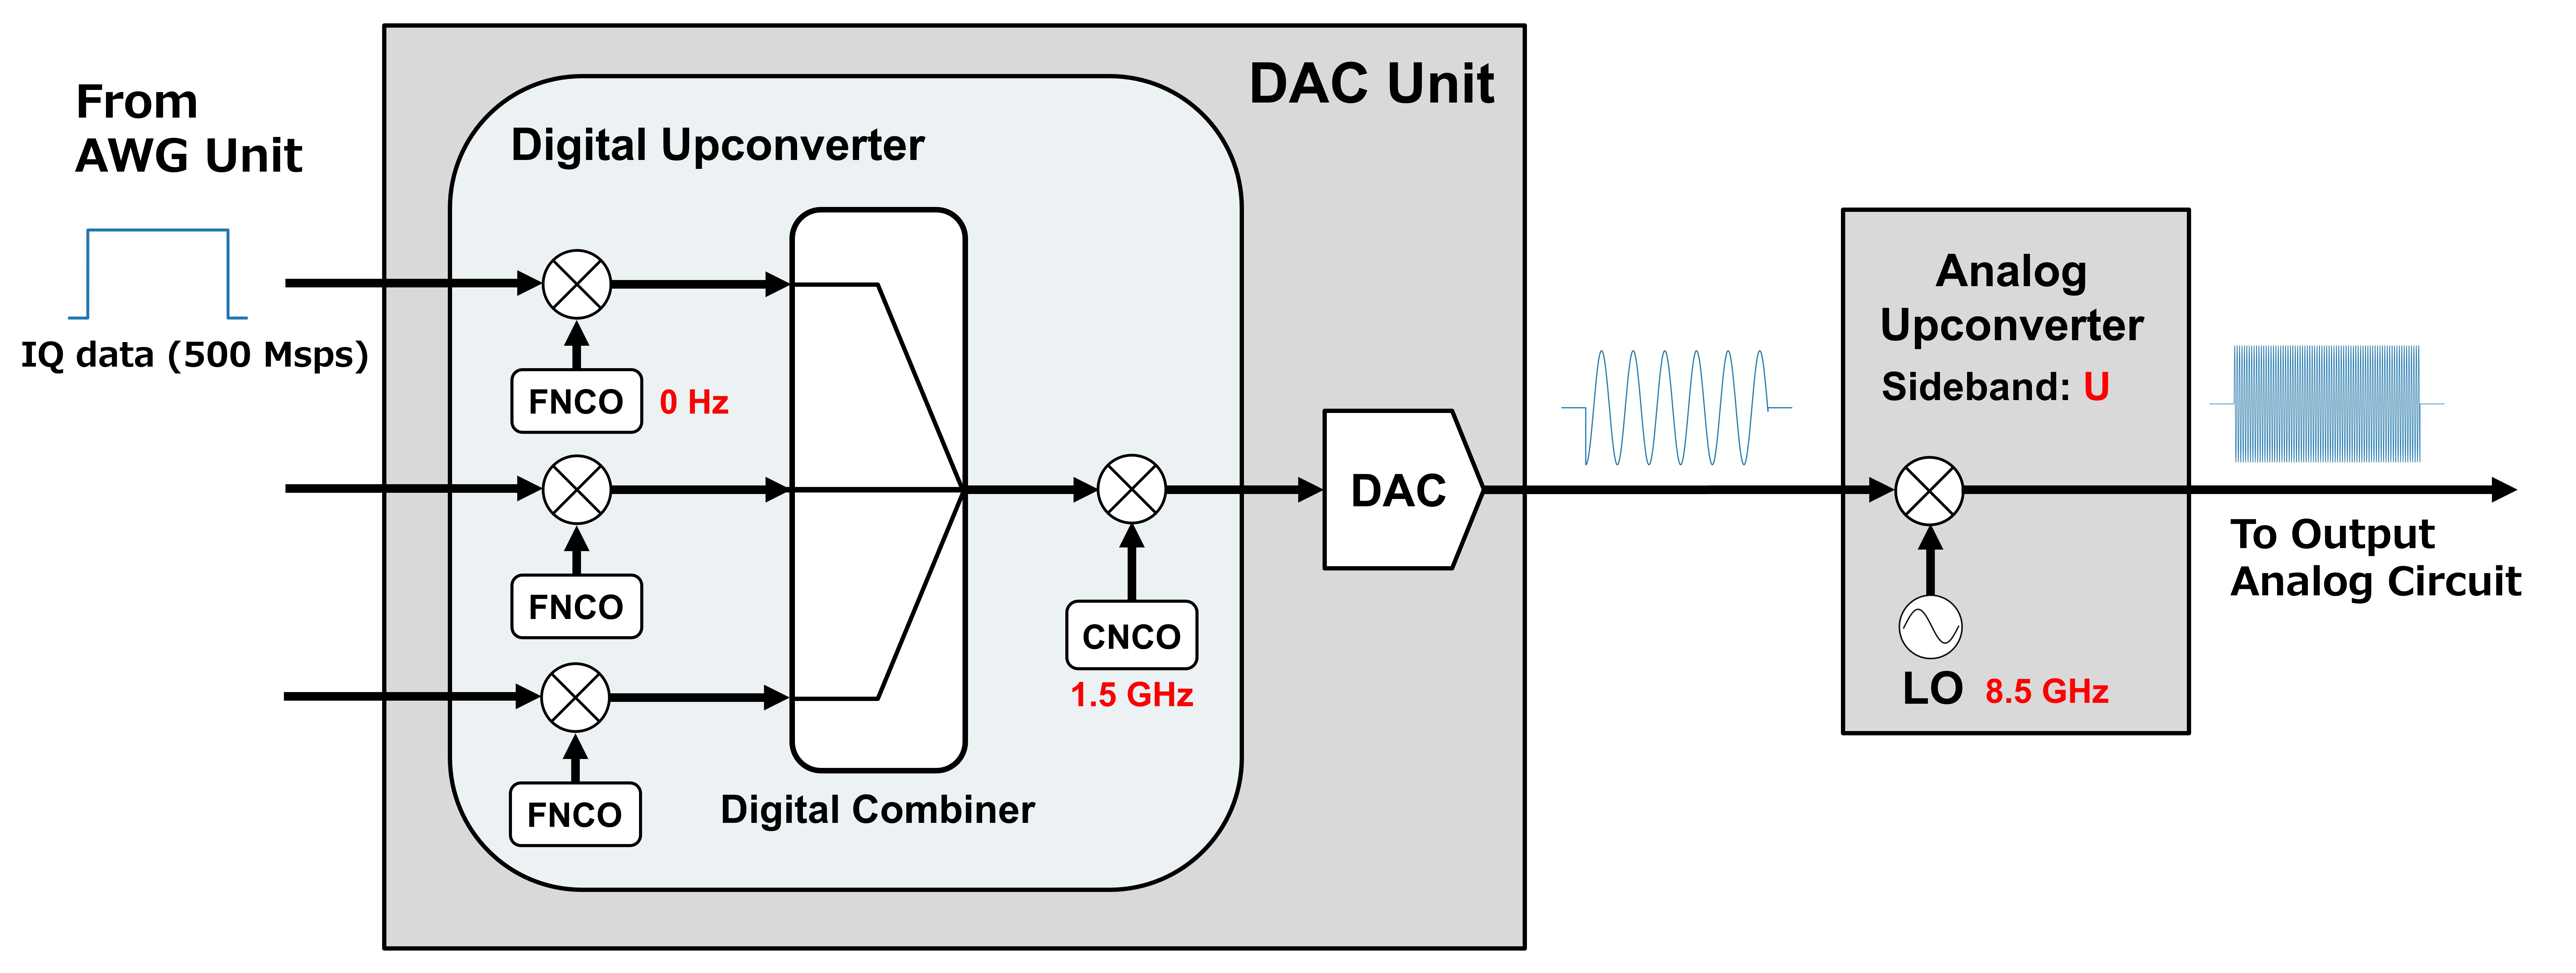

In [1]:
from IPython.display import Image

Image("figs/pulse_gen_quel1.jpg")

## **2. 信号生成と読み出しのデモ**

制御装置の基本的な使用法について、サンプルコードを交えながら説明します。

### **2.1 ループバック機能とモニタ機能について**

本チュートリアルでは、ループバック機能およびモニタ機能を使用して、生成信号の観測デモを行います。
このデモは、実際の量子ビットを使用せず、制御装置単体で行うものです。
混乱を避けるためにも、量子ビットを用いる量子実験と、本チュートリアルで行うデモ実験の違いについて簡単に説明します。

#### **量子実験時における制御装置の使い方**

超伝導量子ビットを用いた実験では、以下の図に示すように、制御装置で生成したマイクロ波パルスは、量子ビットや読み出し共振器に送信されます。
そして読み出し共振器からの反射信号は制御装置に取り込まれ、信号処理が行われます。
これが量子ビットを使用する量子実験の一般的な制御装置の使用方法です。


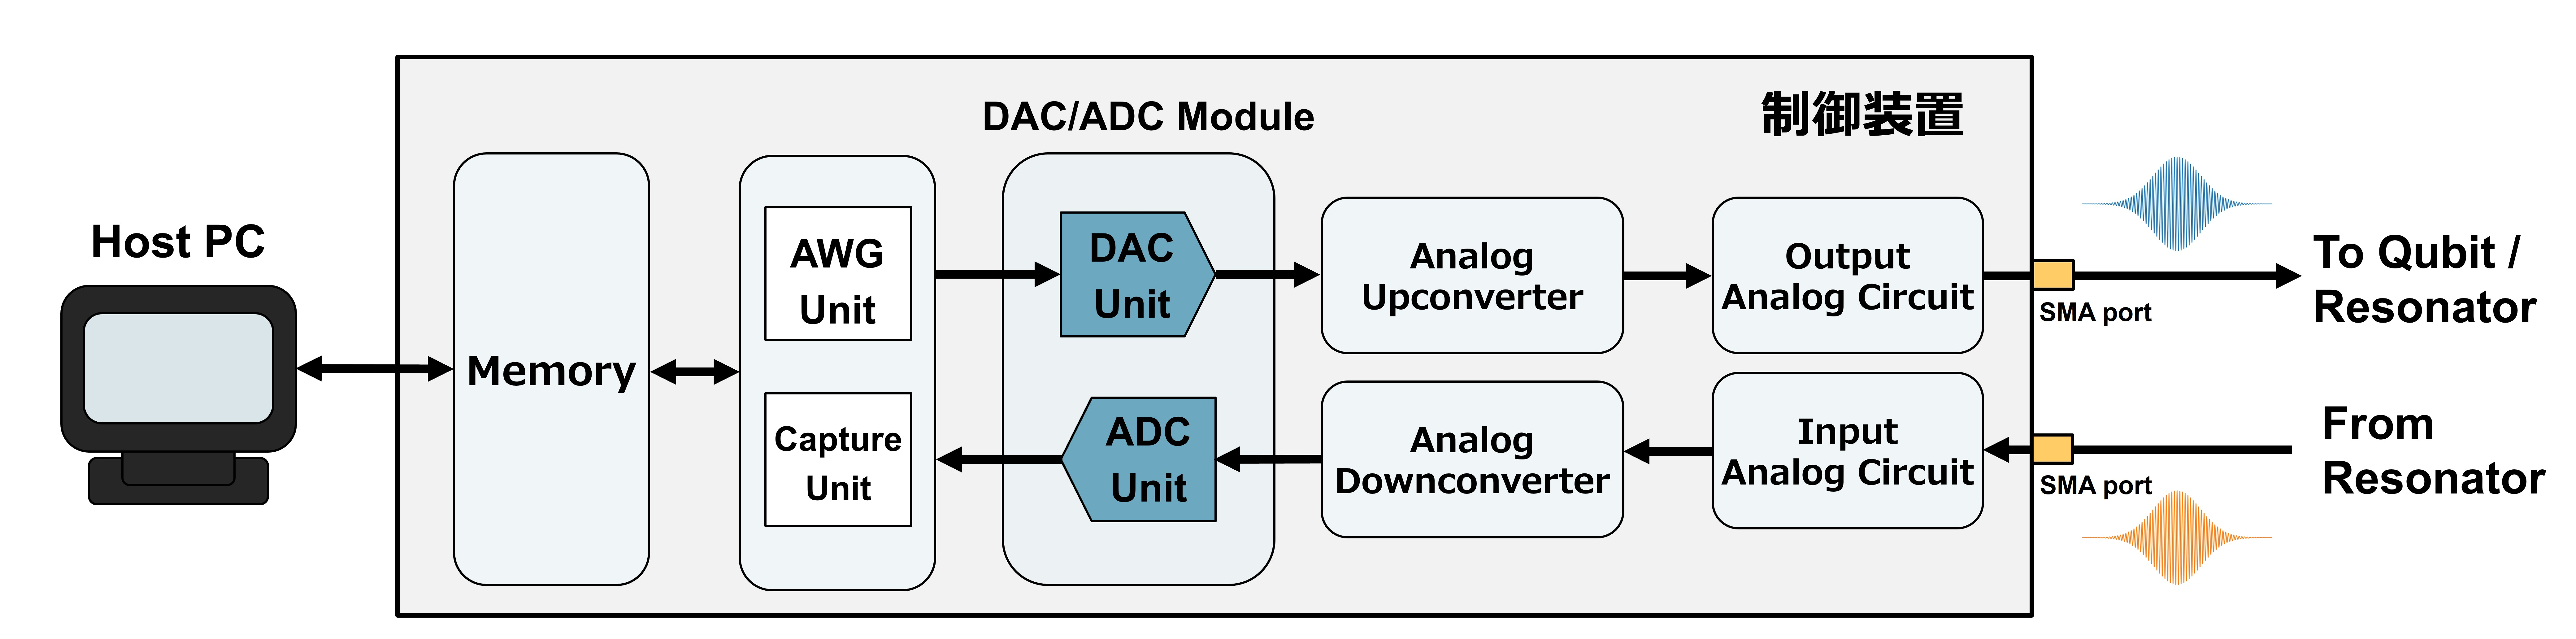

In [2]:
Image("figs/qubit_exp.jpg")

#### **ループバック機能とモニタ機能について**

一方で、本チュートリアルで扱うデモは、量子ビットを使用しない実験です。
ループバック機能とモニタ機能を使用して、生成した信号の観測を行います。
ループバック機能では、RFスイッチを用いて送信信号を内部の受信用回路に直接戻すことができます。
モニタ機能では、方向性結合器を用いて送信信号の一部を受信用回路に送ります。
受信した信号は、アナログ回路でダウンコンバートされます。
その後、ADCユニットがデジタイズを行い、選択した500 MHz 帯域をデジタルフィルタで抽出、ダウンコンバートし、500 Msps のベースバンド信号をキャプチャユニットへ送出します。
これにより、生成した信号のベースバンド信号を観測することができます。

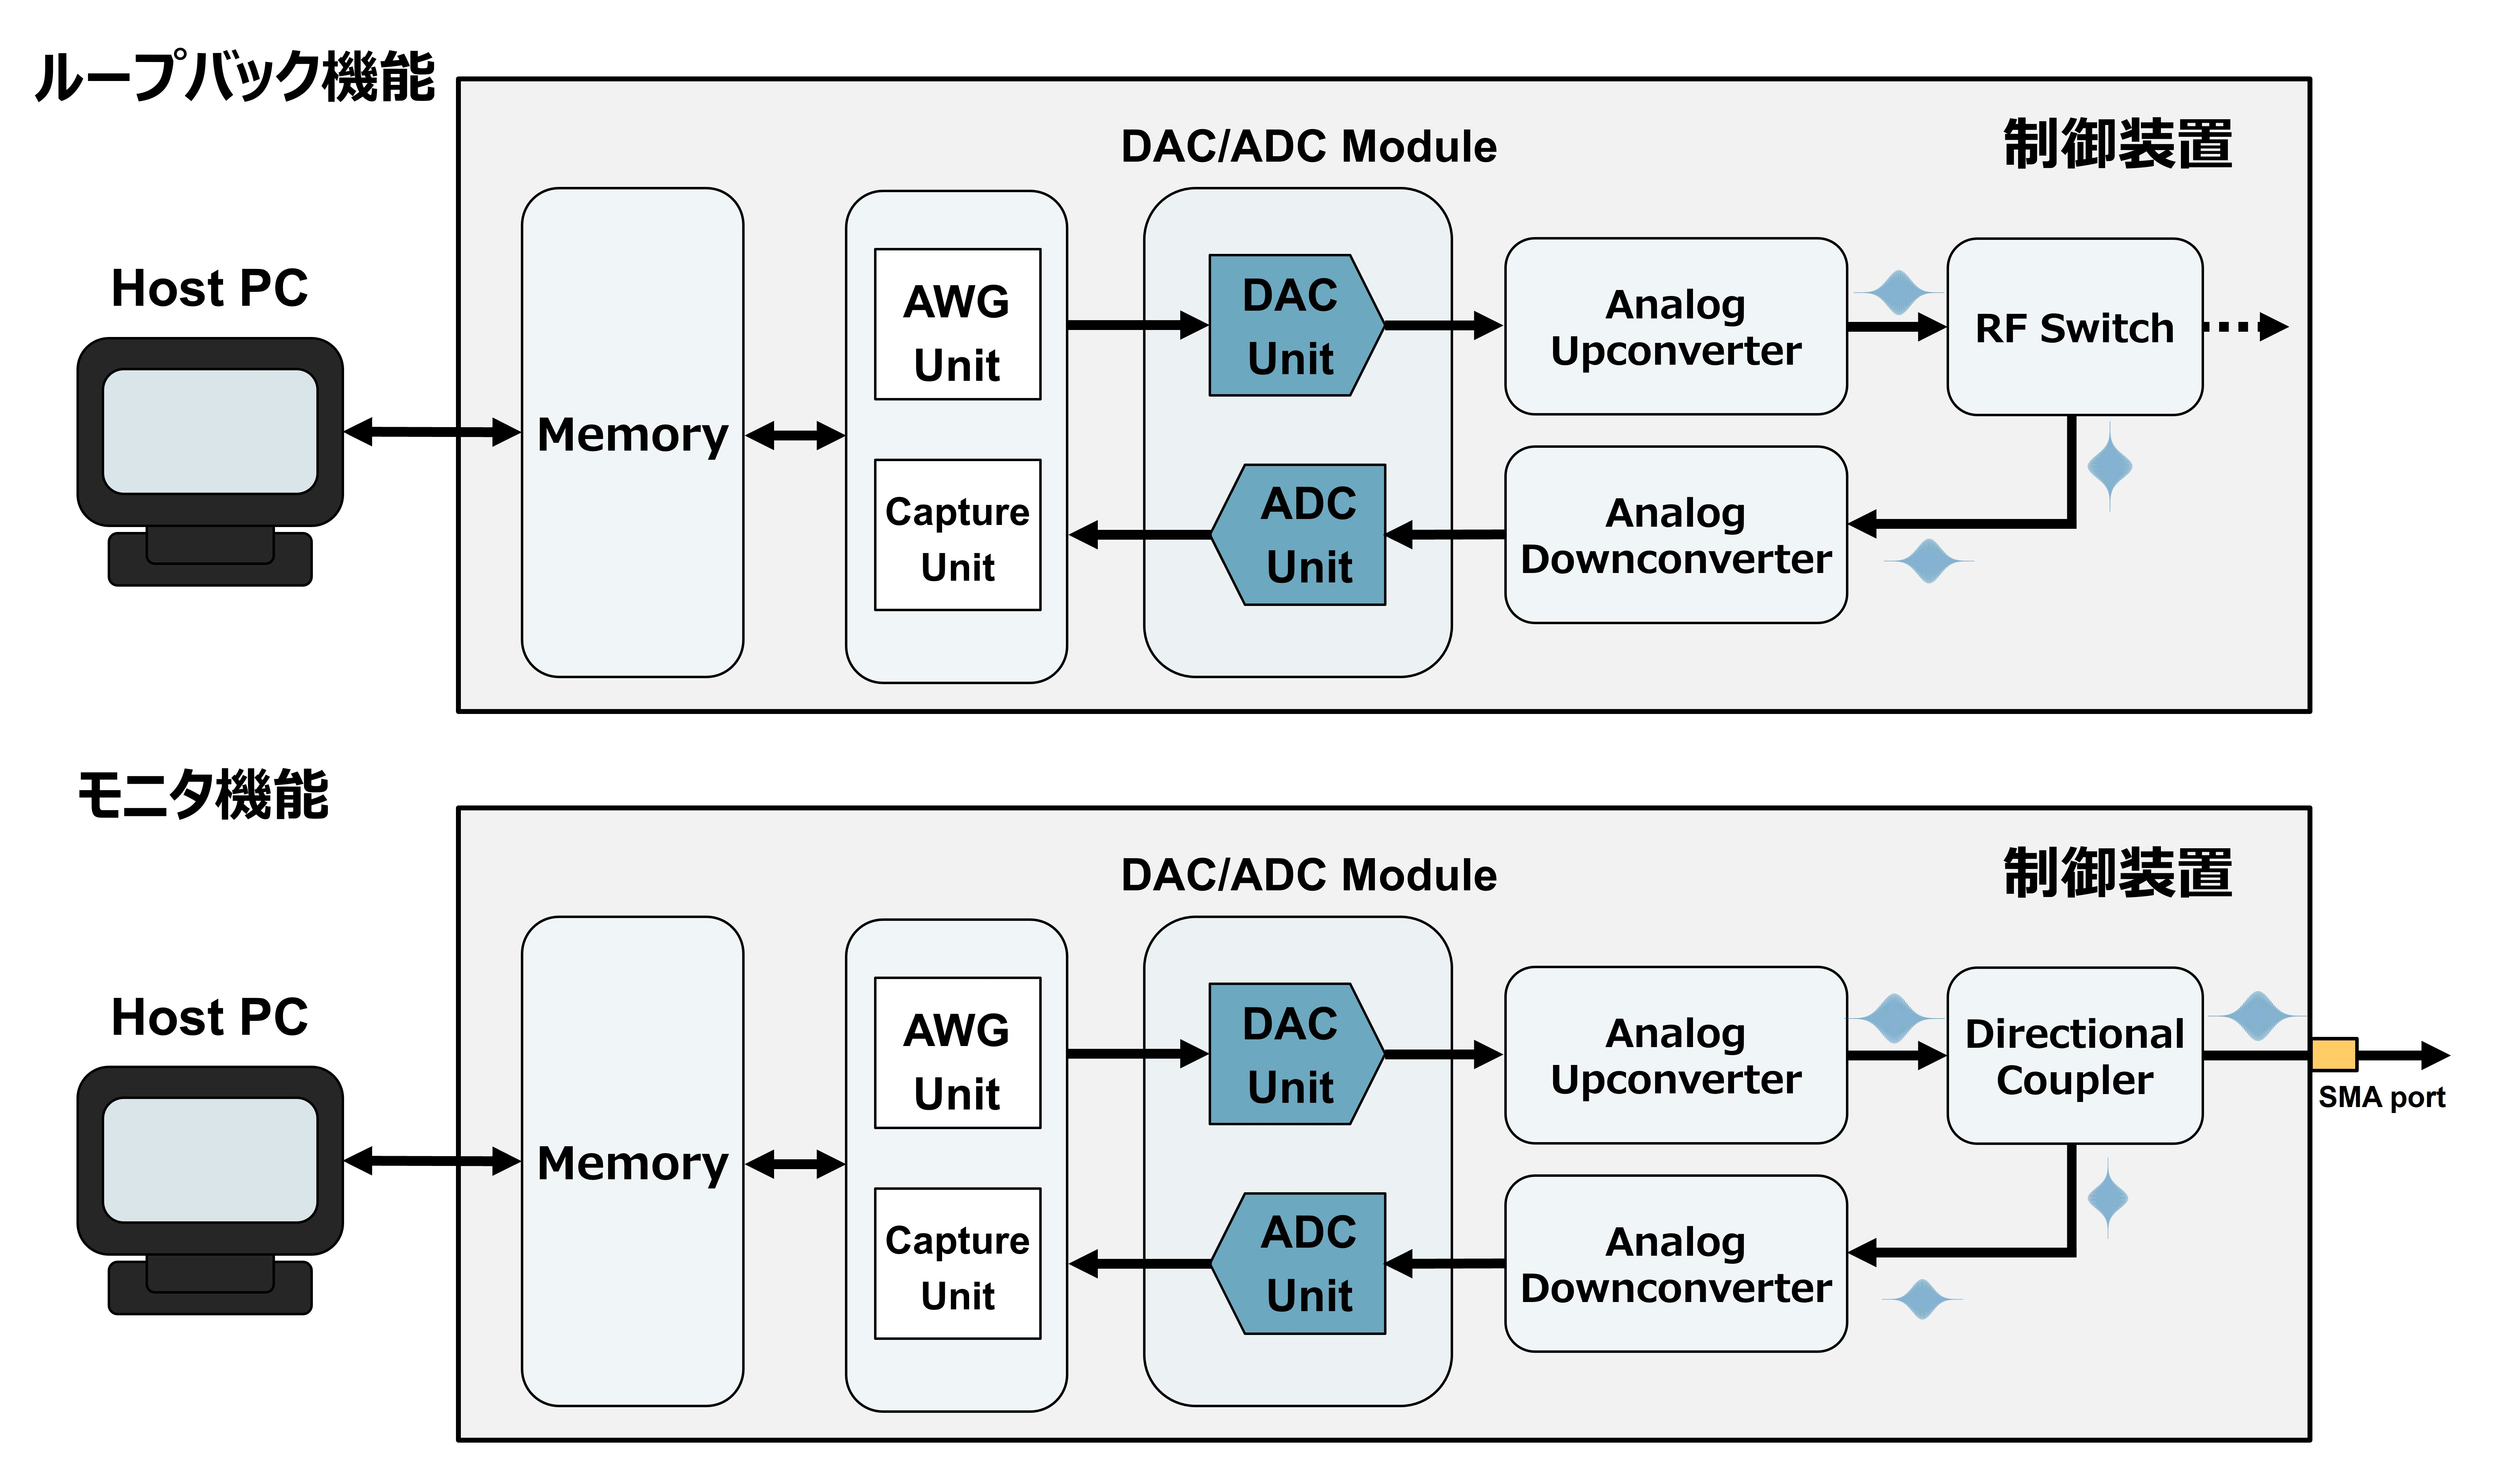

In [3]:
Image("figs/loopback_monitor.jpg")

In [4]:
%matplotlib inline

import numpy as np
from pprint import pprint

from quel_ic_config import Quel1Box, Quel1BoxType, AwgParam, WaveChunk, CapParam, CapSection, force_unlock_all_boxes

from common.qexp_func import square_pulse
from common.utils import plot_iq

### **2.2 リンクアップ**

「リンクアップ」操作とは、制御装置ハードウェアの初期化操作です。
制御装置の電源を投入した後、一度この操作を実施することで、装置を使用可能状態にします。
なお、この操作には約 30 秒かかります。

下のセルでは、まだリンクアップ操作を行っていない制御装置 (IP アドレス: `10.1.0.73`) を想定し、各種パラメタのデフォルト値を記載しています。
ご利用の環境に合わせ、次の2つのパラメタを調整してください。

1. **`BOX_CONFIG["ipaddr_wss"]`**  
   - 使用する制御装置の IP アドレスに書き換えてください。

2. **`execute_linkup`**  
   - **電源投入後、まだリンクアップを実施していない場合**: `True` に設定しリンクアップを実行  
   - **既にリンクアップを実施済みの場合**: `False` に設定することで、リンクアップ処理にかかる時間を短縮できます。

セルを実行し、最終行に `Box is ready to use.` と表示されれば、使用可能状態の装置との接続が確立でき、チュートリアルの続行が可能になります。
なお、途中で警告メッセージが出る場合があります。
サポート時に有用な情報となるので表示していますが、正常に動作している場合には無視して頂いて問題ありません。

一方、エラーメッセージが出た場合には、以下のテーブルを参考にトラブルシューティングを行ってください。

| **エラーメッセージ** | **原因** | **対処方法** |
|:--------------:|:------------:|:-----------------------------------------------------------------------|
| **`No route to host`** | 制御装置へのネットワークアクセスが不能 | ・`BOX_CONFIG["ipaddr_wss"]` が正しいかを確認 <br>・制御装置の電源状態を確認 <br>・制御装置のネットワークケーブルの接続状況を確認 <br>・制御装置にクロックを供給しているクロック分配器の電源状態の確認 (クロック分配器の電源を投入した場合には、10秒程度待ってから、接続されているすべての制御装置の電源を再投入してください。) <br>・クロック分配器と制御装置の接続状況の確認 (クロックケーブルの抜き差しをした制御装置はフリーズしてしまうので、制御装置の電源を再投入してください。) |
| **`failed to acquire lock`**   | 他のノートブックやスクリプトで制御装置を使用中 | ・同じ制御装置に対し別のノートブックを開いている場合は、ノートブックの最後のセルを実行し制御装置を開放させる (`force_unlock_all_boxes`)<br>・他のスクリプトが制御装置を使用している場合はスクリプトを終了させる |
| **`Box is not linked up. ...`**| リンクアップ未実施または失敗 | ・`execute_linkup = True` にして再実行|

稀に偶発的理由でリンクアップ操作が失敗することがありますが、再実行で回復する場合がほとんどです。
リンクアップ操作が繰り返し失敗する場合には、エラー及び警告のメッセージを保存の上、お問い合わせください。
シェルコマンドを使ったリンクアップ操作にて、`--verbose` オプションを付けていただけると詳細なログ情報が得られるので、トラブルシューティングに有効です。詳細については、[別途用意しているドキュメント](https://github.com/quel-inc/quelware/blob/main/quel_ic_config/docs/GETTING_STARTED.md#%E8%A3%85%E7%BD%AE%E3%81%AE%E5%86%8D%E5%88%9D%E6%9C%9F%E5%8C%96%E3%83%AA%E3%83%B3%E3%82%AF%E3%82%A2%E3%83%83%E3%83%97)でご確認ください。  

In [6]:
BOX_CONFIG = {
    "ipaddr_wss": "10.1.0.73",
    "boxtype": Quel1BoxType.fromstr("quel1-a"),
}

force_unlock_all_boxes()  # boxを再作成する場合に、古いboxが握っているロックの解除を確実にする

# Box オブジェクトの作成と初期化
box = Quel1Box.create(**BOX_CONFIG)

# 制御装置とホストの通信確立
execute_linkup = True
if execute_linkup:
    print("Box is being linked up...")
    status = box.relinkup()
else:
    status = box.reconnect()

# リンクアップの状態を確認
if all(status.values()):
    print("Box is ready to use.")
else:
    print("Box is not linked up. Please execute relinkup.")

Box is being linked up...
Box is ready to use.


### **2.3 ループバックでの読み出し**

制御装置におけるパラメータ設定の方法を理解するために、前述の 384 ns のパルス長を持つ 10 GHz の矩形波パルスの生成を実際に行います。
また、制御装置のループバック機能を活用して、生成したベースバンド信号の波形を観測します。
具体的には、ポート1で矩形波パルスを生成し、その信号をポート0で観測するプロセスを紹介します。

#### **ポートの周波数設定**

パルスの生成と観測に必要なポートの周波数設定は、全ポートの周波数設定が含まれている `port_config_quel1` という JSON ファイルを通じて行います。
設定例は以下のとおりです:

In [7]:
box.config_box_from_jsonfile("port_config_quel1.json")

ポート設定の確認は、次のように行います。

In [8]:
port_dump = box.dump_box()["ports"]
pprint(port_dump)

{0: {'cnco_freq': 1500000000.0,
     'direction': 'in',
     'lo_freq': 8500000000,
     'rfswitch': 'loop',
     'runits': {0: {'fnco_freq': 0.0},
                1: {'fnco_freq': 0.0},
                2: {'fnco_freq': 0.0},
                3: {'fnco_freq': 0.0}}},
 1: {'channels': {0: {'fnco_freq': 0.0}},
     'cnco_freq': 1500000000.0,
     'direction': 'out',
     'fullscale_current': 40527,
     'lo_freq': 8500000000,
     'rfswitch': 'block',
     'sideband': 'U',
     'vatt': 2560},
 2: {'channels': {0: {'fnco_freq': 0.0},
                  1: {'fnco_freq': 0.0},
                  2: {'fnco_freq': 0.0}},
     'cnco_freq': 1500000000.0,
     'direction': 'out',
     'fullscale_current': 40527,
     'lo_freq': 9500000000,
     'rfswitch': 'block',
     'sideband': 'L',
     'vatt': 2560},
 3: {'channels': {0: {'fnco_freq': 0.0}},
     'cnco_freq': 1500000000.0,
     'direction': 'out',
     'fullscale_current': 40527,
     'lo_freq': 11500000000,
     'rfswitch': 'block',
     'si

ここで、ポート0とポート1の設定内容を確認してみます。

#### **ポート1の設定内容**

パルスを生成するポート1の設定内容は以下のとおりです。

- FNCO の周波数 (`fnco_freq`): 0 Hz
- CNCO の周波数 (`cnco_freq`): 1.5 GHz
- LO 信号の周波数 (`lo_freq`): 8.5 GHz
- アナログミキサの出力モード選択 (`sideband`): `U`

これらの設定により、ポート0は、$f_{LO} + f_{cnco} = 8.5 + 1.5 = 10.0$ GHz の信号を出力します。
出力信号の振幅は可変アッテネータ (`vatt`) の値を変更することで調整可能です。 

In [9]:
pprint(port_dump[1])

{'channels': {0: {'fnco_freq': 0.0}},
 'cnco_freq': 1500000000.0,
 'direction': 'out',
 'fullscale_current': 40527,
 'lo_freq': 8500000000,
 'rfswitch': 'block',
 'sideband': 'U',
 'vatt': 2560}


#### **ポート0の設定内容**

ポート0ではポート1で生成されたパルスの観測を行います。ポート0の設定は以下のとおりです。

- FNCO の周波数 (`fnco_freq`): 0 Hz
- CNCO の周波数 (`cnco_freq`): 1.5 GHz
- LO 信号の周波数 (`lo_freq`): 8.5 GHz

In [10]:
pprint(port_dump[0])

{'cnco_freq': 1500000000.0,
 'direction': 'in',
 'lo_freq': 8500000000,
 'rfswitch': 'loop',
 'runits': {0: {'fnco_freq': 0.0},
            1: {'fnco_freq': 0.0},
            2: {'fnco_freq': 0.0},
            3: {'fnco_freq': 0.0}}}


#### **波形データの設定**

周波数の設定が完了した後、次にベースバンド信号の設定を行います。
想定している 384 ns (128 ns $\times$ 3) のパルス長の矩形波に対応する波形データを用意します。

**時間パラメータの設定**
- 時間のパラメータは、128 ns で設定しています。また、制御装置の DAC のサンプリングレートは 2 ns なので、128 ns の各タイムパラメータを2で割り、必要なサンプル数を算出します。

**AWG への波形ロード**
- 生成した矩形波のデータは、`box.register_wavedata` を使用してAWG の対応するチャネルにロードします。

<Figure size 640x480 with 0 Axes>

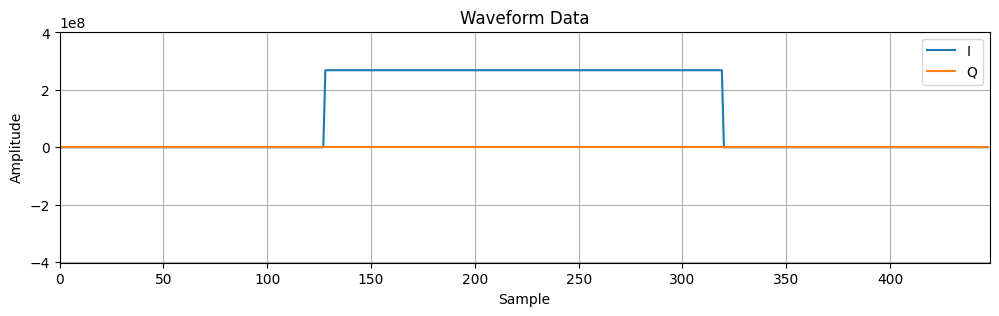

In [ ]:
# 各パラメータは 128 ns の倍数で設定
time_blank1 = 128 * 2  # 最初の無信号区間
time_flat = 128 * 3  # 矩形波の長さ
time_blank2 = 128 * 2  # 最後の無信号区間

# サンプル数（2 ns / sampling）
num_blank1_sample = time_blank1 // 2
num_blank2_sample = time_blank2 // 2
num_flat_sample = time_flat // 2

time_total = time_blank1 + time_flat + time_blank2
num_total_samples = num_blank1_sample + num_flat_sample + num_blank2_sample

# 制御信号の矩形波を生成
wave = square_pulse(num_blank1_sample, num_flat_sample, num_blank2_sample)
plot_iq(wave, np.max(abs(wave)) * 1.5, "Waveform Data")

# 生成した矩形波のiqデータを port #1 の AWG に登録
box.register_wavedata(port=1, channel=0, name="square-1", iq=wave)

# 矩形波を1回発生する波形パラメタを作成
awg_param_port1 = AwgParam(num_repeat=1)
awg_param_port1.chunks.append(WaveChunk(name_of_wavedata="square-1"))

# 波形パラメタを port #1 の AWG に入力
box.config_channel(
    port=1,
    channel=0,
    awg_param=awg_param_port1,
)

#### **読み出しシーケンスの設定と実行**

実際に、ポート1で生成した信号をポート0で観測してみます。
具体的な読み出しの手順は以下のとおりです。

1. `delay` の設定:
読み出しを開始する前に、信号のキャプチャ開始前の待機時間を指定するパラメータ `delay` を設定します。
以下の例では、`delay` を 128 $\times$ 4 ns と設定しています。
この遅延の主な要因は、DAC/ADC の信号処理パイプラインのレイテンシによるものです。

2. `CapParam` の作成:
波形のキャプチャに必要なパラメータを設定します。
`box.config_runit` の引数に作成した `CapParam` を渡すことで、キャプチャの準備が完了します。

3. 信号の出力開始:
`box.start_capture_by_awg_trigger` メソッドを用いて、ポート0、チャネル0の runit とポート1、チャネル0の出力チャネルを同時に起動し、現在時刻から 0.1 秒後に波形生成と取得を一斉に開始します。

4. 結果の取得:
`thunk_ro.result()` を呼び出して信号出力の終了を確認します。
波形のキャプチャ結果は、`thunk_ri.result()` を使用して取得します。


5. 結果の表示:
`plot_iq` 関数を使用して、キャプチャされたIQデータをグラフに表示します。


<Figure size 640x480 with 0 Axes>

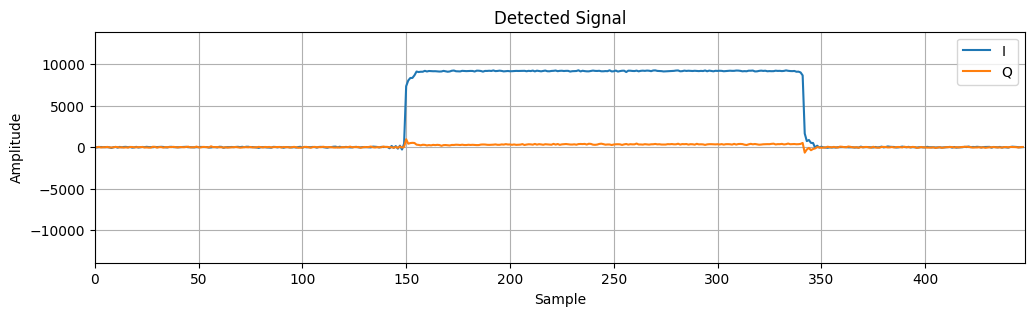

In [12]:
# Capture 開始までの delay の設定
delay_samples = 128 * 4

# 読み出しのシーケンスを作成
cap_param_ri = CapParam(num_repeat=1, num_wait_word=delay_samples // 4)
cap_param_ri.sections.append(CapSection(name="sec0", num_capture_word=num_total_samples // 4))

# 読み出しシーケンスを設定
box.config_runit(0, 0, capture_param=cap_param_ri)


# 出力と読み出しを0.1秒後に一斉に開始
cur = box.get_current_timecounter()  # 現在の時刻カウンタを取得
thunk_ri, thunk_ro = box.start_capture_by_awg_trigger(
    {(0, 0)},
    {(1, 0)},
    cur + 125_000_000 // 10,
)

# 出力終了を確認
thunk_ro.result()

# 読み出し終了を確認して、結果を取得。
iqs_ri_readers = thunk_ri.result()
iqs_ri = iqs_ri_readers[0, 0].as_wave_dict()["sec0"]
iq_ri = iqs_ri[0]

# グラフを表示
plot_iq(iq_ri, np.max(abs(iq_ri)) * 1.5, "Detected Signal")

このグラフは、ポート1で生成した信号をポート0で観測した結果を示しています。
縦軸はADCからの読み取り値を、横軸はサンプル番号を示しており、サンプリングレートが 500 Msps であるため、各サンプルは 2 ns の時間に相当します。
観測された信号の位相に回転が見られますが、この位相のずれは信号処理においては通常問題にはなりません。
重要なのはキャプチャされたデータ全体が一定の位相を保っていることであり、示されたデータからは位相が安定していることが確認できます。

### **2.4 モニタによる信号の読み出し**

次に、384 ns のパルス長を持つ 10.0 GHz の矩形波パルスをポート4で出力し、それを制御装置のモニタ機能を用いて、ポート5で読み出します。

In [13]:
selected_ports = {
    4: port_dump[4],
    5: port_dump[5],
}

pprint(selected_ports)

{4: {'channels': {0: {'fnco_freq': 0.0},
                  1: {'fnco_freq': 0.0},
                  2: {'fnco_freq': 0.0}},
     'cnco_freq': 1500000000.0,
     'direction': 'out',
     'fullscale_current': 40527,
     'lo_freq': 11500000000,
     'rfswitch': 'block',
     'sideband': 'L',
     'vatt': 2560},
 5: {'cnco_freq': 1500000000.0,
     'direction': 'in',
     'lo_freq': 11500000000,
     'rfswitch': 'loop',
     'runits': {0: {'fnco_freq': 0.0}}}}


以下のコードで信号の生成とモニタ機能を用いた読み出しが実行可能です。

<Figure size 640x480 with 0 Axes>

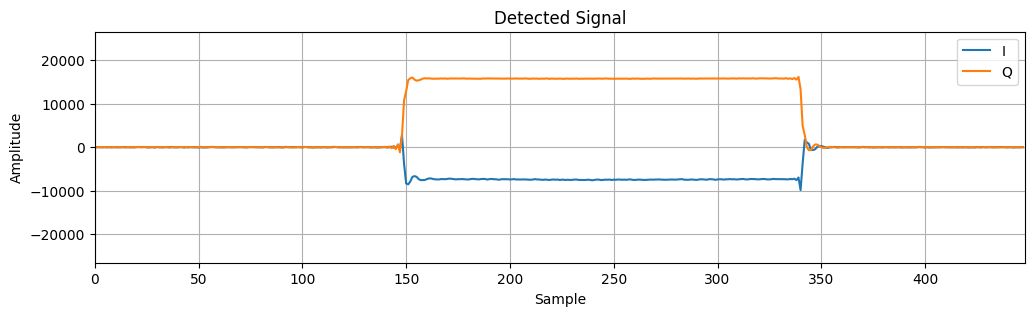

In [ ]:
# 生成した矩形波のiqデータを port #4 の AWG に登録
box.register_wavedata(port=4, channel=0, name="square-1", iq=wave)

# 矩形波を1回発生する波形パラメタを作成
awg_param_port = AwgParam(num_repeat=1)
awg_param_port.chunks.append(WaveChunk(name_of_wavedata="square-1"))

# 波形パラメタを port #4 の AWG に入力
box.config_channel(
    port=4,
    channel=0,
    awg_param=awg_param_port,
)

# 読み出しシーケンスの作成
cap_param_mon = CapParam(num_repeat=1, num_wait_word=delay_samples // 4)
cap_param_mon.sections.append(CapSection(name="sec0", num_capture_word=num_total_samples // 4))

# 読み出しシーケンスを設定
box.config_runit(5, 0, capture_param=cap_param_mon)

# 出力と読み出しを0.1秒後に一斉に開始
cur = box.get_current_timecounter()
thunk_mon, thunk_p4 = box.start_capture_by_awg_trigger(
    {(5, 0)},
    {(4, 0)},
    cur + 125_000_000 // 10,
)

# 出力終了を確認
thunk_p4.result()

# 読み出し終了を確認して、結果を取得。
iqs_mon_readers = thunk_mon.result()
iqs_mon = iqs_mon_readers[5, 0].as_wave_dict()["sec0"]
iq_mon = iqs_mon[0]

# グラフを表示
plot_iq(iq_mon, np.max(abs(iq_mon)) * 1.5, "Detected Signal")

## **3. 制御装置の解放** 

実験が終了したら制御装置のロックを解放します。
ロックを解放しないと、他のノートブックから制御装置へのアクセスができません。

In [15]:
force_unlock_all_boxes()

### **バージョン確認**

In [16]:
import quel_ic_config

quel_ic_config.__version__

'0.10.1rc1'